In [22]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split

from data import generate_data, generate_observation_matrix
from loss import create_mc_loss
from network import init_net, compute_end_to_end, compute_factor, compress_network
from solver import train, compute_dlr
from utils import compose, svd

In [23]:
key = PRNGKey(0)

# Generate data
r = 50
d = 5000
depth = 3
init_type = "orth"
init_scale = 1e-2

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

key, subkey = split(key)
init_weights = init_net(key=subkey, input_dim=d, output_dim=d, width=d, depth=depth, init_type=init_type, init_scale=init_scale)

key, subkey = split(key)
percent_observed = 0.20
mask = generate_observation_matrix(key=subkey, percent_observed=percent_observed, shape=(d, d))

train_mc_loss_fn = create_mc_loss(target, mask)
test_mc_loss_fn = create_mc_loss(target, 1 - mask)
train_e2e_loss_fn = compose(train_mc_loss_fn, compute_end_to_end)
test_e2e_loss_fn = compose(test_mc_loss_fn, compute_end_to_end)

tol = 1e-10
step_size = 1e5
n_outer_loops = 1000

In [24]:
original_step_size = step_size
original_result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=original_step_size,
    test_e2e_loss_fn=test_e2e_loss_fn,
    tol=tol
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
V = compute_factor(init_weights=init_weights, e2e_loss_fn=train_e2e_loss_fn, grad_rank=r)
comp_init_weights = compress_network(init_weights, V, r)
comp_step_size = compute_dlr(step_size=step_size, depth=len(comp_init_weights), prop=0.01)

comp_result = train(
    init_weights=comp_init_weights,
    train_e2e_loss_fn=train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=comp_step_size,
    test_e2e_loss_fn=test_e2e_loss_fn,
    tol=tol
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
# Narrow, width=r
key, subkey = split(key)
narrow_r_init_weights = init_net(key=subkey, input_dim=d, output_dim=d, width=r, depth=depth, init_type=init_type, init_scale=init_scale)
narrow_r_step_size = step_size
narrow_r_result = train(
    init_weights=narrow_r_init_weights,
    train_e2e_loss_fn=train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=narrow_r_step_size,
    test_e2e_loss_fn=test_e2e_loss_fn,
    tol=tol
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
# Narrow, width=2r
key, subkey = split(key)
narrow_2r_init_weights = init_net(key=subkey, input_dim=d, output_dim=d, width=2*r, depth=depth, init_type=init_type, init_scale=init_scale)
narrow_2r_step_size = step_size
narrow_2r_result = train(
    init_weights=narrow_2r_init_weights,
    train_e2e_loss_fn=train_e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=narrow_2r_step_size,
    test_e2e_loss_fn=test_e2e_loss_fn,
    tol=tol
)

  0%|          | 0/1000 [00:00<?, ?it/s]

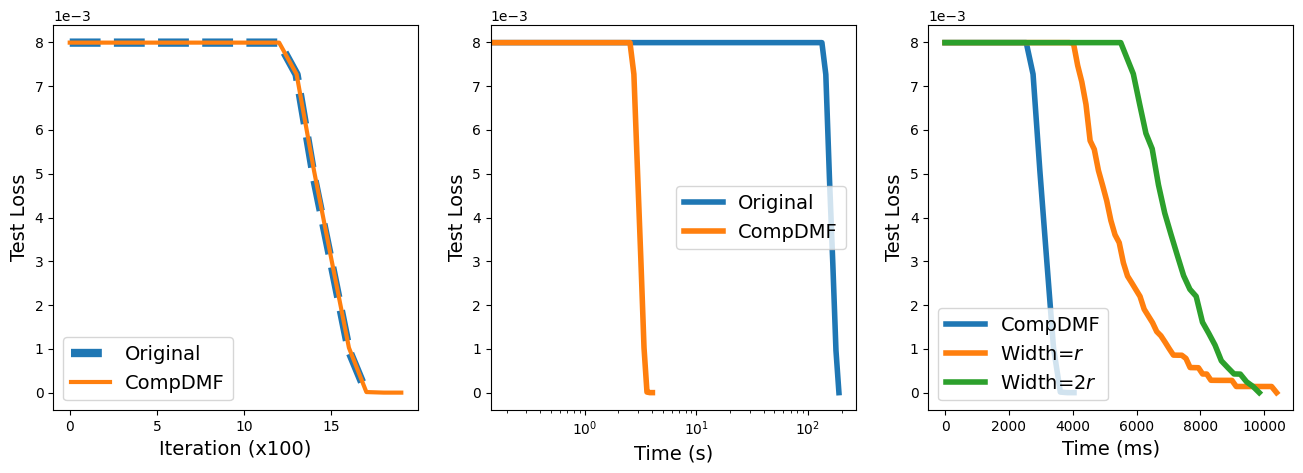

In [28]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 5))

axes[0].plot(original_result['test_loss'], linewidth=6, linestyle='--', label='Original')
axes[0].plot(comp_result['test_loss'], linewidth=3, label='CompDMF')
axes[0].set_xlabel('Iteration (x100)', fontsize=14)
axes[0].set_ylabel('Test Loss', fontsize=14)
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].legend(fontsize=14)

axes[1].semilogx(original_result['time'], original_result['test_loss'], linewidth=4, label='Original')
axes[1].semilogx(comp_result['time'], comp_result['test_loss'], linewidth=4, label='CompDMF')
axes[1].set_xlabel('Time (s)', fontsize=14)
axes[1].set_ylabel('Test Loss', fontsize=14)
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1].legend(fontsize=14)

axes[2].plot(1000*comp_result['time'], comp_result['test_loss'], linewidth=4, label='CompDMF')
axes[2].plot(1000*narrow_r_result['time'], narrow_r_result['test_loss'], linewidth=4, label='Width=$r$')
axes[2].plot(1000*narrow_2r_result['time'], narrow_2r_result['test_loss'], linewidth=4, label='Width=$2r$')
axes[2].set_xlabel('Time (ms)', fontsize=14)
axes[2].set_ylabel('Test Loss', fontsize=14)
axes[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[2].legend(fontsize=14)

# plt.savefig('figs/comp_v_orig.png', dpi=300, bbox_inches='tight')